In [1]:
%autosave 60

Autosaving every 60 seconds


In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# System
import os

# Arrays
import numpy as np

# Data analysis
import pandas as pd

# Machine learning
from sklearn.model_selection import train_test_split

# Deep learning 
from keras.models import Model
from keras.layers import Lambda, Input, Dense
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Internal functions
from __functions import sampling

Using TensorFlow backend.
/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.7
  return f(*args, **kwds)


Get data

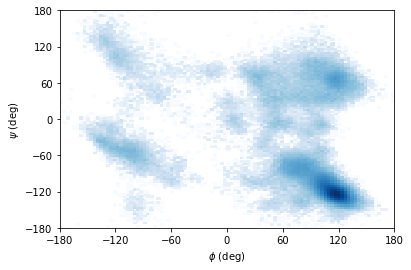

In [2]:
# Define path to structure files
filepath = "../datasets/MD_datasets.csv"
datasets = pd.read_csv(filepath,
                       names=["phi", "psi"])

# visualize
fig, ax = plt.subplots()

ax.axis([-180,180,-180,180])
ax.set(xticks=range(-180, 181, 60), yticks=range(-180, 181, 60),
        xlabel=r"$\phi$ (deg)", ylabel=r"$\psi$ (deg)")
    
r = datasets['phi']
u = datasets['psi']

ax.hist2d(np.rad2deg(r), np.rad2deg(u), 
          bins=100, range=[[-180,180],[-180,180]], 
          norm=LogNorm(), cmap=plt.cm.Blues)

plt.show()

Variational Autoencoder
-----
Explain variational autoencoder with bayesian reparameterization trick. Instead of sampling from $Q(z|X)$, sample $\epsilon = N(0,1)$ with $z = z_{mean} + \sqrt{\sigma}*\epsilon$

In [34]:
# System variables
residues, frames, types = 428, 600, 2

# Reshape datasets
# dim = frames * ( residues * types )
dat = datasets.values.astype('float32')
dat = dat.reshape(frames, residues*types)

# Splitting the dataset into training and test sets
x_train, x_tests = train_test_split(dat, test_size = 0.2)

Define VAE model parameters

In [37]:
# Data dimension
dataset_dim = np.prod(datasets.shape)
initial_dim = residues * types

# Network parameters
input_shape = (initial_dim, )
hidden_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

Build __encoder__ model

In [38]:
# VAE (encoder + decoder): Input -> Hidden -> Lambda -> Hidden -> Output
# Build encoder model: Input -> Hidden -> Lambda

# Input layer
inputs = Input(shape=input_shape, name='encoder_input')

# Intermediate layer
x = Dense(hidden_dim, activation='relu')(inputs)

# Stochastic layer
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# Instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# plot model
plot_model(encoder, 
           to_file='vae_mlp_encoder.png', 
           show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 856)          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          438784      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_2[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_2[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

Build __decoder__ model

In [39]:
# Latent input
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

# Intermediate layer
y = Dense(hidden_dim, activation='relu')(latent_inputs)

# Output layer
outputs = Dense(initial_dim, activation='sigmoid')(y)

# Instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# plot model
plot_model(decoder, 
           to_file='vae_mlp_decoder.png', 
           show_shapes=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1536      
_________________________________________________________________
dense_4 (Dense)              (None, 856)               439128    
Total params: 440,664
Trainable params: 440,664
Non-trainable params: 0
_________________________________________________________________


In [40]:
# Instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

Run the model on the data

In [42]:
# VAE loss = mse_loss or xent_loss + kl_loss
#\ reconstruction_loss = mse(inputs, outputs)
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= initial_dim

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
vae.summary()

plot_model(vae, 
           to_file='vae_mlp.png', 
           show_shapes=True)

# Train the autoencoder
vae.fit(x_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(x_tests, None))

# Save model
vae.save_weights('vae_mlp_mnist.h5')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 856)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 440836    
_________________________________________________________________
decoder (Model)              (None, 856)               440664    
Total params: 881,500
Trainable params: 881,500
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 480 samples, validate on 120 samples
Epoch 1/50
480/480 [==============================] - 1s 2ms/step - loss: 661.5824 - val_loss: 85708.3203
Epoch 2/50
480/480 [==============================] - 0s 593us/step - loss: 20160.1402 - val_loss: -5145.8081
Epoch 3/50
480/480 [==============================] - 0s 625us/step - loss: -6884.7989 - v

Plot results

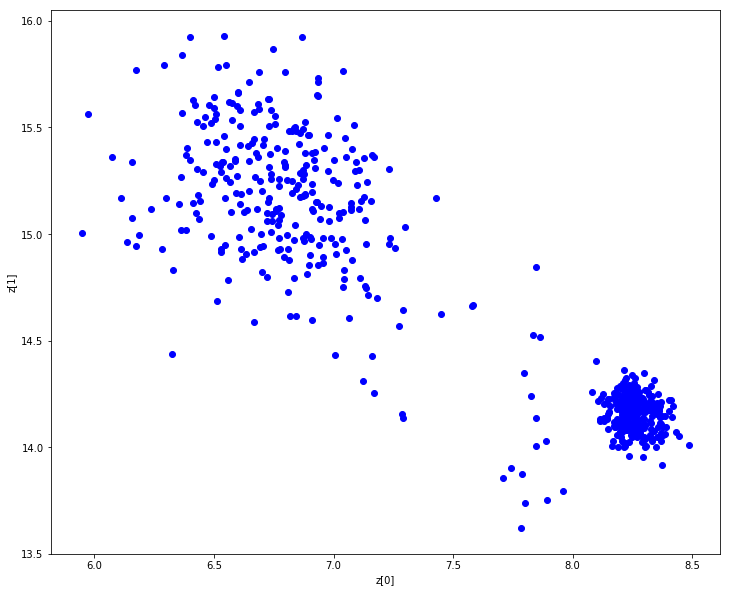

In [50]:
# display a 2D plot of the digit classes in the latent space
z_mean, _, _ = encoder.predict(dat, batch_size=128)
    
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c='blue')
#plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.savefig("vae_mean.png")
plt.show()